# Our goal is to produce an hybrid (quantum - classical) machine learning model to predict digits between 0 and 9

We will reproduce the quantum machine learning that was used in 2304.09224. The hybrid network models has the form:


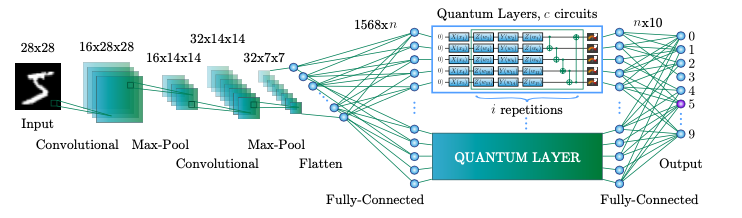


$n$ is the number of input features that we pass into the quantum layer. Each quantum layer takes $q$ features (5 in Fig above) and therefore we have a total of $c = n/q$ circuits. The constitution of the circuit is as follow:

- Angle Embedding: embeds the input features into quantum qubits. It takes 1 feature -> 1 qubit.
- $i$ repetitions of the strongly entangling layers (`StronglyEntanglingLayers` of PennyLane).
- List of all qubit measurements in the $Y$ basis.




In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, BatchNormalization, Activation, Reshape, Lambda
import numpy as np
import pandas as pd
import pennylane as qml
import matplotlib.pyplot as plt
# Load and preprocess the dataset
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()


# Shuffle the training dataset
np.random.seed(2)
perm = np.random.permutation(len(train_images))
train_images = train_images[perm]
train_labels = train_labels[perm]

# Shuffle the test dataset
perm = np.random.permutation(len(test_images))
test_images = test_images[perm]
test_labels = test_labels[perm]


## TRANSFORM TO ONE-HOT-ENCODING
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=0)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=0)


## Scale it to 1
train_images = train_images / 255.0
test_images = test_images / 255.0


In [ ]:
train_images.shape, test_images.shape

In [ ]:
train_labels

In [ ]:
# Display the first 10 images from the training set
plt.imshow(train_images[0], cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
m = 35
n_qubits = 5
n_qm_circuit = int(m/n_qubits)
n_layers = 3
# ----------------------------------------------------------------------------------------------------------------------------------------
## LAYER 1

layers_1 = [Conv2D(16, (3, 3), padding='same', strides=(1, 1), input_shape=(28, 28, 1)),  # 16 filters, output: 26x26x16
            BatchNormalization(), Activation('relu'), 
    MaxPooling2D((2, 2)),  # Max pooling, output: 14x14x16
    Conv2D(32, (1, 1)),  # 32 filters, output: 14x14x32
    BatchNormalization(), Activation('relu'), 
    MaxPooling2D((2, 2)),  # Max pooling, output: 6x6x32
    Flatten(),  # Flatten the output for dense layers
    Dense(m)
    ]


# ----------------------------------------------------------------------------------------------------------------------------------------

## QUANTUM LAYER

dev = qml.device('default.qubit', wires=range(n_qubits))
@qml.qnode(dev, diff_method="backprop", interface="tf")
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    for i in range(n_layers):
        #qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
        qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]


# weight_shapes = {"weights": (n_layers, n_qubits)} # BasicEntanglerLayers
weight_shapes = {"weights": qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)}

## Makes the quantum circuit Keras compatible
qlayers = []
for i in range(n_qm_circuit):
    qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)
    qlayers.append(qlayer)

### AN EXAMPLE
# weights = np.random.rand(n_layers, n_qubits) # BasicEntanglerLayer
shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
weights = np.random.random(size=shape)

inputs = np.random.rand(n_qubits)
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(qnode)(inputs, weights)
plt.show()


# ----------------------------------------------------------------------------------------------------------------------------------------# ----------------------------------------------------------------------------------------------------------------------------------------

# SECOND LAYER

layers_2 = Dense(10, activation="softmax")


# ----------------------------------------------------------------------------------------------------------------------------------------



#### Creating the model

We cannot create the model sequentially using `Sequential()`

In [ ]:
input_data = tf.keras.Input(shape=(28, 28, 1))
x = input_data

for layer in layers_1:
    x = layer(x)

output_layer1 = Lambda(lambda x: tf.split(x, n_qm_circuit, axis=1))(x)
output2 = [qlayer(out) for q_layer, out in zip(qlayers, output_layer1)]
output3 = tf.concat(output2, axis=1)
outputs = layers_2(output3)
qm_model = tf.keras.Model(inputs=input_data, outputs=outputs)


opt = tf.keras.optimizers.Adam(learning_rate=0.02)
qm_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

qm_model.summary()

# ----------------------------------------------------------------------------------------------------------------------------------------#
## TESTING
import time
from time import time as tm

n = 2
start_time = tm()
input_data  = train_images[0:n] # Look at the sample of 2 images
out = qm_model(input_data)
print(f"The shape of the output is: {out.shape}, and it took {round(tm()-start_time, 2)} seconds to run")

## Running the model (TAKES VERY LONG)

In [12]:
PREPROCESS = False; ## IF TRUE, IT WILL RUN THE MODEL (TAKES ABOUT 2 HRS). WE RUN IT AND RECORD THE VALUES


if PREPROCESS == True:
    tf.get_logger().setLevel('ERROR')
    
    
    qm_fitting = qm_model.fit(train_images[:700], train_labels[:700], epochs=5, batch_size=5, validation_data=(test_images[:200], test_labels[:200]), verbose=2)


else:
    import pickle
    
    
    
    # Load the history from the file
    with open('./checkpoints/qm_fitting.pkl', 'rb') as f:
        qm_fitting = pickle.load(f)
    
    # Now you can access the training history dictionary
    print(qm_fitting.keys())
    
    # You can load the weights back later using:
    with open("./checkpoints/qm_model_weights.pkl", 'rb') as f:
        weights = pickle.load(f)
    qm_model.set_weights(weights)


Epoch 1/5
140/140 - 1467s - loss: 1.2275 - accuracy: 0.6286 - val_loss: 1.0157 - val_accuracy: 0.7150 - 1467s/epoch - 10s/step
Epoch 2/5
140/140 - 1432s - loss: 0.7216 - accuracy: 0.7986 - val_loss: 0.6966 - val_accuracy: 0.7750 - 1432s/epoch - 10s/step
Epoch 3/5
140/140 - 1198s - loss: 0.5469 - accuracy: 0.8371 - val_loss: 1.5427 - val_accuracy: 0.4250 - 1198s/epoch - 9s/step
Epoch 4/5
140/140 - 1219s - loss: 0.3990 - accuracy: 0.8829 - val_loss: 0.5872 - val_accuracy: 0.7900 - 1219s/epoch - 9s/step
Epoch 5/5
140/140 - 1327s - loss: 0.3348 - accuracy: 0.8986 - val_loss: 0.4493 - val_accuracy: 0.8850 - 1327s/epoch - 9s/step


FROM OUR RUN

Epoch 1/5
140/140 - 1467s - loss: 1.2275 - accuracy: 0.6286 - val_loss: 1.0157 - val_accuracy: 0.7150 - 1467s/epoch - 10s/step
Epoch 2/5
140/140 - 1432s - loss: 0.7216 - accuracy: 0.7986 - val_loss: 0.6966 - val_accuracy: 0.7750 - 1432s/epoch - 10s/step
Epoch 3/5
140/140 - 1198s - loss: 0.5469 - accuracy: 0.8371 - val_loss: 1.5427 - val_accuracy: 0.4250 - 1198s/epoch - 9s/step
Epoch 4/5
140/140 - 1219s - loss: 0.3990 - accuracy: 0.8829 - val_loss: 0.5872 - val_accuracy: 0.7900 - 1219s/epoch - 9s/step
Epoch 5/5
140/140 - 1327s - loss: 0.3348 - accuracy: 0.8986 - val_loss: 0.4493 - val_accuracy: 0.8850 - 1327s/epoch - 9s/step


We save the history (qm_model_fitting) and the weights of the model. So we can just
create a new model and re-define it.

In [84]:
qm_model.evaluate(train_images[:700], train_labels[:700])

22/22 [==============================] - 76s 3s/step - loss: 0.1611 - accuracy: 0.9600


[0.16111528873443604, 0.9599999785423279]

#### SCRAP (TIME TEST OF ALL LAYERS)

In [ ]:
### TEST OF OUR MODEL
import time
from time import time as tm

n = 25
input_data  = train_images[0:n] # Look at the sample of 2 images
input_data = np.reshape(input_data, (n, 28, 28, 1)) # Reshape data for batch dimensions
#print(input_data)
start_time = tm()
step_time = start_time
time_list = [[], [], []]
for layer in layers_1:
    input_data = layer(input_data)
    time_list[0].append(tm()-step_time)
    step_time = tm()
    

print(input_data.shape) # Should be (2, 100)

step_time = tm()

output_layer1 = Lambda(lambda x: tf.split(x, n_qm_circuit, axis=1))(input_data)
time_list[1].append(tm()-step_time)
print(output_layer1[0].shape) # Should be (2, 5)

step_time = tm()
output_qlayer = [qlayer(out) for q_layer, out in zip(qlayers, output_layer1)]
time_list[1].append(tm()-step_time)
print(output_qlayer[0].shape) # Should be (2, 5)

step_time = tm()
output3 = tf.concat(output_qlayer, axis=1)
time_list[1].append(tm()-step_time)
print(output3.shape) # Should be (2, 100)

step_time = tm()
outputs = layers_2(output3);
time_list[2].append(tm()-step_time)
print(outputs.shape)

layers_time = [sum(layer_time) for layer_time in time_list]
print(f"Time taken to run {n} images for layer 1: {layers_time[0]}, for layer 2: {layers_time[1]}, for layer 3: {layers_time[2]}")


### Loss and Accuracy comparison


- `loss`: gives the value of the loss function: $\mathcal{L} = -\sum^k_{c=1} y_c \log{(p_c)}$ for the **training** dataset. Recall for the loss function that y is the output between 0 and 1 of the neural networks and t being the training value (also either 0 or 1). 
- `binary_accuracy`: Represents the accuracy of the model on the **training** dataset. Measures the percentage of correct predictions for the **training** dataset.
- `val_loss`: gives the value of the loss function. A large gap between `loss` and `val_loss` is an indicative of overfitting.
- `val_binary_accuracy`: same as `binary_accuracy`, but for the **validation** dataset. Again, a large gap between the two is indicative of overf

In [100]:
# Get the training and validation loss
qm_loss = qm_fitting['loss']
qm_val_loss = qm_fitting['val_loss']

# Get the training and validation accuracy
qm_binary_accuracy = qm_fitting['accuracy']
qm_val_binary_accuracy = qm_fitting['val_accuracy']

313/313 [==============================] - 869s 3s/step - loss: 0.4513 - accuracy: 0.8626

Validation Loss: 0.45131412148475647, Validation Accuracy: 0.8626000285148621


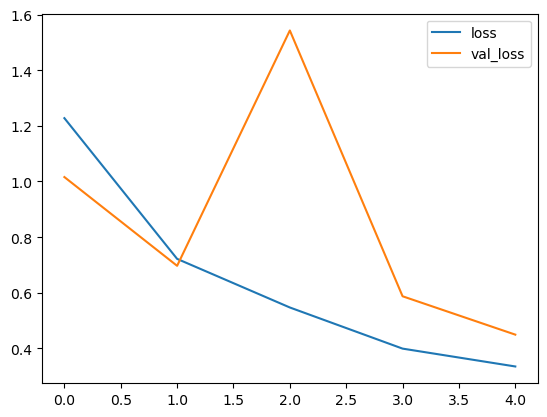

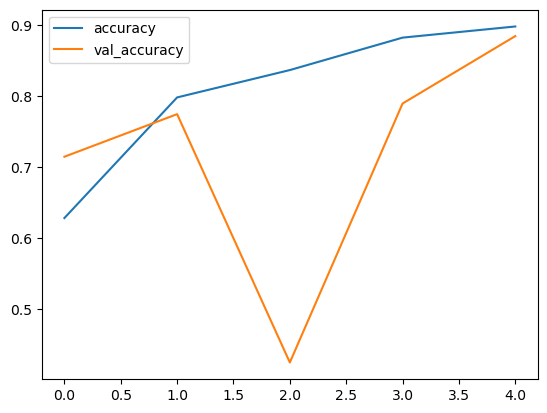

In [101]:
qm_history_df = pd.DataFrame(qm_fitting)

qm_history_df[['loss', 'val_loss']].plot()
qm_history_df[['accuracy', 'val_accuracy']].plot()
qm_loss, qm_accuracy = qm_model.evaluate(test_images, test_labels)
print()
print(f"Validation Loss: {qm_loss}, Validation Accuracy: {qm_accuracy}")

# Classical Analogue of the hybrid model 
The quantum model is replaced with a classical dense layer with $m$ neurons.

In [193]:
### COMPARING WITHOUT THE
m = 35
n_qubits = 5
n_qm_circuit = int(m/n_qubits)

layers_1 = [Conv2D(16, (3, 3), padding='same', strides=(1, 1), input_shape=(28, 28, 1)),  # 16 filters, output: 26x26x16
            BatchNormalization(), Activation('relu'), 
    MaxPooling2D((2, 2)),  # Max pooling, output: 14x14x16
    Conv2D(32, (1, 1)),  # 32 filters, output: 14x14x32
    BatchNormalization(), Activation('relu'), 
    MaxPooling2D((2, 2)),  # Max pooling, output: 6x6x32
    Flatten(),  # Flatten the output for dense layers
    Dense(m)
    ]
# ------------------------------------------------------------------------------------------------------------------------------------

# Create the second layers:
layers_2 = [Dense(10, activation="softmax")]

# ------------------------------------------------------------------------------------------------------------------------------------


class_model = Sequential(layers_1 + [Dense(m, activation="relu")] + layers_2)
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
class_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


# ------------------------------------------------------------------------------------------------------------------------------------


class_model(train_images[0:n]);


# ------------------------------------------------------------------------------------------------------------------------------------
class_model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 batch_normalization_18 (Bat  (None, 28, 28, 16)       64        
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 14, 14, 32)        544       
                                                                 
 batch_normalization_19 (Bat  (None, 14, 14, 32)      

In [194]:
PREPROCESSING = False;

if PREPROCESSING == True:
    tf.get_logger().setLevel('ERROR')
    class_fitting = class_model.fit(train_images[:2000], train_labels[:2000], epochs=20, batch_size=5, validation_data=(test_images[:200], test_labels[:200]), verbose=2)



else:
    import pickle
    ## Save class_fitting dinamycally since it takes so long to run
    
    # Load the history from the file
    with open('./checkpoints/class_fitting.pkl', 'rb') as f:
        class_fitting = pickle.load(f)
    
    # You can load the weights back later using:
    with open("./checkpoints/class_model_weights.pkl", 'rb') as f:
        weights = pickle.load(f)
    class_model.set_weights(weights)




Epoch 1/20
400/400 - 4s - loss: 1.2620 - accuracy: 0.6570 - val_loss: 0.6432 - val_accuracy: 0.8150 - 4s/epoch - 11ms/step
Epoch 2/20
400/400 - 3s - loss: 0.3792 - accuracy: 0.8795 - val_loss: 0.2862 - val_accuracy: 0.9100 - 3s/epoch - 6ms/step
Epoch 3/20
400/400 - 3s - loss: 0.2555 - accuracy: 0.9190 - val_loss: 0.5541 - val_accuracy: 0.8550 - 3s/epoch - 6ms/step
Epoch 4/20
400/400 - 3s - loss: 0.2717 - accuracy: 0.9180 - val_loss: 0.5717 - val_accuracy: 0.8650 - 3s/epoch - 7ms/step
Epoch 5/20
400/400 - 3s - loss: 0.2637 - accuracy: 0.9195 - val_loss: 0.3187 - val_accuracy: 0.8800 - 3s/epoch - 7ms/step
Epoch 6/20
400/400 - 3s - loss: 0.2465 - accuracy: 0.9235 - val_loss: 0.3543 - val_accuracy: 0.9150 - 3s/epoch - 8ms/step
Epoch 7/20
400/400 - 3s - loss: 0.2008 - accuracy: 0.9405 - val_loss: 0.3095 - val_accuracy: 0.9100 - 3s/epoch - 8ms/step
Epoch 8/20
400/400 - 3s - loss: 0.1859 - accuracy: 0.9445 - val_loss: 0.6405 - val_accuracy: 0.8350 - 3s/epoch - 7ms/step
Epoch 9/20
400/400 - 3s

In [195]:
import pickle


with open('./checkpoints/class_fitting.pkl', 'wb') as f:
    pickle.dump(class_fitting, f)



# Save the weights to a file
with open("./checkpoints/class_fitting_weights.pkl", 'wb') as f:
    pickle.dump(class_model.get_weights(), f)



In [196]:
print(class_fitting.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [197]:
# Get the training and validation loss
class_loss = class_fitting.history['loss']
class_val_loss = class_fitting.history['val_loss']

# Get the training and validation accuracy
class_binary_accuracy = class_fitting.history['accuracy']
class_val_binary_accuracy = class_fitting.history['val_accuracy']

313/313 [==============================] - 3s 9ms/step - loss: 0.3843 - accuracy: 0.9344

Validation Loss: 0.38427993655204773, Validation Accuracy: 0.9344000220298767


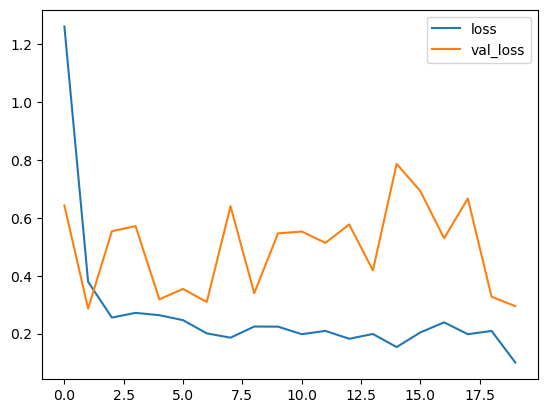

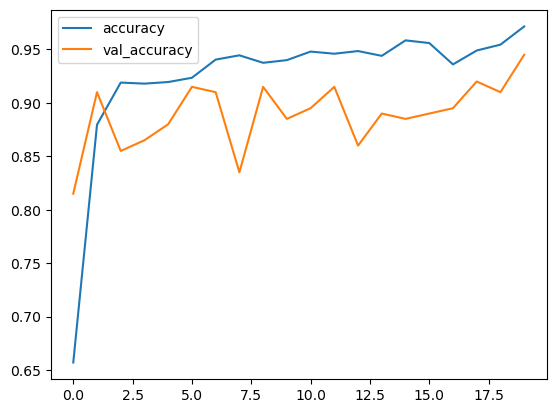

In [198]:
class_history_df = pd.DataFrame(class_fitting.history)

class_history_df[['loss', 'val_loss']].plot()
class_history_df[['accuracy', 'val_accuracy']].plot()
class_loss, class_accuracy = class_model.evaluate(test_images, test_labels)
print()
print(f"Validation Loss: {class_loss}, Validation Accuracy: {class_accuracy}")

# RESULT

Both methods are similarly accurate, but the hybrid model contains less parameters and a smaller sample for comparable accuracy. However, it takes significantly longer to run. 

# We will also produce a quanvolution instead of a classical convolution (i.e. changing the layer 1)

The quantum convolution consists of:
- Taking a 4x4 pixels sub-images of our 32x32 images and embed it into a 4x4=16 qubits quantum circuit.
- The quantum circuits embed the classical data using simple rotations: `qml.RY` and an $U$ operator chosen to be random: `RandomLayers`
- A list of measurements of all the qubits in the Z basis

In [229]:
import pennylane as qml
from pennylane import numpy as npp
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [230]:
# RELOAD THE DATA
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, BatchNormalization, Activation, Reshape, Lambda
import numpy as np
import pandas as pd
import pennylane as qml
import matplotlib.pyplot as plt
# Load and preprocess the dataset
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()


# Shuffle the training dataset
np.random.seed(2)
perm = np.random.permutation(len(train_images))
train_images = train_images[perm]
train_labels = train_labels[perm]

# Shuffle the test dataset
perm = np.random.permutation(len(test_images))
test_images = test_images[perm]
test_labels = test_labels[perm]


## TRANSFORM TO ONE-HOT-ENCODING
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=0)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=0)


## Scale it to 1
train_images = train_images / 255.0
test_images = test_images / 255.0

In [231]:
n_epochs = 20   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 500    # Size of the train dataset
n_test = 50    # Size of the test dataset


SAVE_PATH = "./"  # Data saving folder

np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [232]:
# Add extra dimension for convolution channels
train_images = npp.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = npp.array(test_images[..., tf.newaxis], requires_grad=False)

In [233]:
train_images.shape

(60000, 28, 28, 1)

In [234]:
dev = qml.device("default.qubit", wires=16)  # Change the number of wires to 16 for a 4x4 region

# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 16))  # Update the size of rand_params to match the number of wires

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 16 classical input values (4x4 region)
    for j in range(16):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(16)))

    # Measurement producing 16 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(16)]

In [235]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((13, 13, 16))  # Assuming the output shape for a 4x4 convolution

    # Loop over the coordinates of the top-left pixel of 4x4 squares
    for j in range(0, 28, 4):
        for k in range(0, 28, 4):
            # Process a squared 4x4 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0], image[j, k + 1, 0], image[j, k + 2, 0], image[j, k + 3, 0],
                    image[j + 1, k, 0], image[j + 1, k + 1, 0], image[j + 1, k + 2, 0], image[j + 1, k + 3, 0],
                    image[j + 2, k, 0], image[j + 2, k + 1, 0], image[j + 2, k + 2, 0], image[j + 2, k + 3, 0],
                    image[j + 3, k, 0], image[j + 3, k + 1, 0], image[j + 3, k + 2, 0], image[j + 3, k + 3, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j//4, k//4)
            for c in range(16):
                out[j // 4, k // 4, c] = q_results[c]
    return out

In [278]:
PREPROCESS = False;


if PREPROCESS == True:

    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images[:n_train]):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images[:n_test]):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "/quantumconvol/"+ "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "/quantumconvol/"+ "q_test_images.npy", q_test_images)

else:
    # Load pre-processed images
    q_train_images = np.load(SAVE_PATH + "/quantumconvol/"+ "q_train_images.npy")
    q_test_images = np.load(SAVE_PATH + "/quantumconvol/" + "q_test_images.npy")


In [279]:
q_train_images.shape

(500, 13, 13, 16)

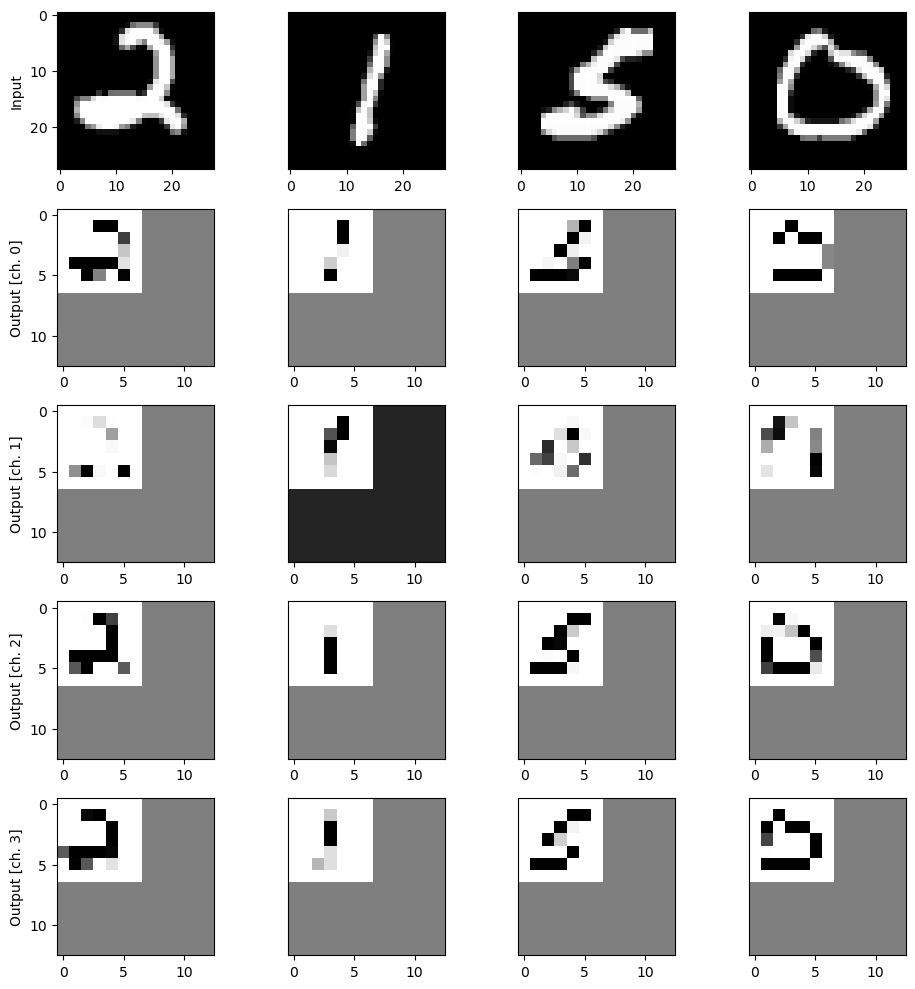

In [280]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, k].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, k].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c + 1, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()


## Now that we have the convolution, we pass it through the hybrid model

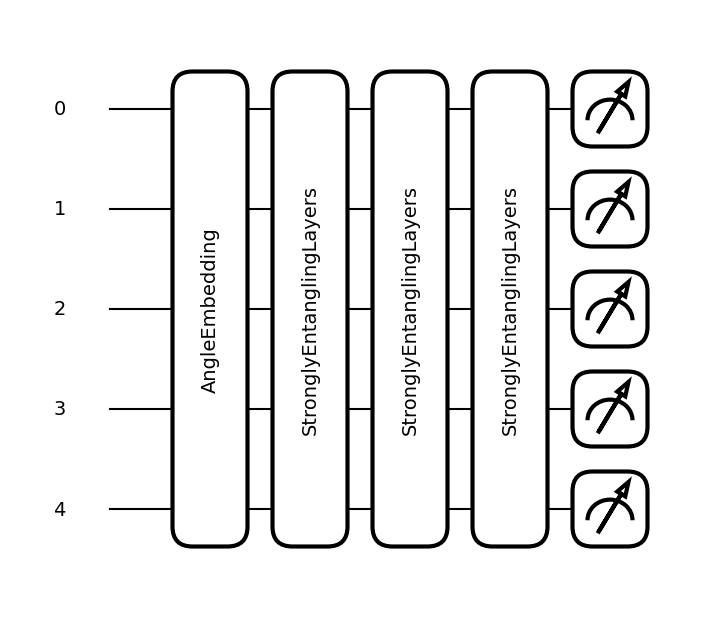

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 13, 13, 16)  0           []                               
                                ]                                                                 
                                                                                                  
 flatten_39 (Flatten)           (None, 2704)         0           ['input_27[0][0]']               
                                                                                                  
 dense_95 (Dense)               (None, 35)           94675       ['flatten_39[0][0]']             
                                                                                                  
 lambda_27 (Lambda)             [(None, 5),          0           ['dense_95[0][0]']        

In [287]:
m = 35
n_qubits = 5
n_qm_circuit = int(m/n_qubits)
n_layers = 3
# ----------------------------------------------------------------------------------------------------------------------------------------
## LAYER 1

layers_1 = [
    Flatten(),  # Flatten the output for dense layers
    Dense(m) # Dense layer
    ]


# ----------------------------------------------------------------------------------------------------------------------------------------

## QUANTUM LAYER

dev = qml.device('default.qubit', wires=range(n_qubits))
@qml.qnode(dev, diff_method="backprop", interface="tf")
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    for i in range(n_layers):
        #qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
        qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]


# weight_shapes = {"weights": (n_layers, n_qubits)} # BasicEntanglerLayers
weight_shapes = {"weights": qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)}

## Makes the quantum circuit Keras compatible
qlayers = []
for i in range(n_qm_circuit):
    qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)
    qlayers.append(qlayer)

### AN EXAMPLE
# weights = np.random.rand(n_layers, n_qubits) # BasicEntanglerLayer
shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
weights = np.random.random(size=shape)

inputs = np.random.rand(n_qubits)
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(qnode)(inputs, weights)
plt.show()


# ----------------------------------------------------------------------------------------------------------------------------------------# ----------------------------------------------------------------------------------------------------------------------------------------

# SECOND LAYER

layers_2 = Dense(10, activation="softmax")
# ----------------------------------------------------------------------------------------------------------------------------------------


input_data = tf.keras.Input(shape=(13, 13, 16))
x = input_data

for layer in layers_1:
    x = layer(x)

output_layer1 = Lambda(lambda x: tf.split(x, n_qm_circuit, axis=1))(x)
output2 = [qlayer(out) for q_layer, out in zip(qlayers, output_layer1)]
output3 = tf.concat(output2, axis=1)
outputs = layers_2(output3)
qm_conv_qm_model = tf.keras.Model(inputs=input_data, outputs=outputs)


opt = tf.keras.optimizers.Adam(learning_rate=0.02)
qm_conv_qm_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

qm_conv_qm_model.summary()


# ----------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
PREPROCESS = True; ## IF TRUE, IT WILL RUN THE MODEL (TAKES ABOUT 2 HRS). WE RUN IT AND RECORD THE VALUES

if PREPROCESS == True: 
    # Fit the model
    qm_conv_qm_fitting = qm_conv_qm_model.fit(q_train_images, train_labels[:n_train], epochs=5, batch_size=5, validation_data=(q_test_images[:50], test_labels[:50]), verbose=2)

else:
    ## Save qm_conv_qm_fitting dinamycally since it takes so long to run
    import pickle
    
    # Load the history from the file
    with open('./checkpoints/qm_conv_qm_fitting.pkl', 'rb') as f:
        qm_conv_qm_fitting = pickle.load(f)
    
    # You can load the weights back later using:
    with open("./checkpoints/qm_conv_qm_weights.pkl", 'rb') as f:
        weights = pickle.load(f)
    qm_conv_qm_model.set_weights(weights)
    


Epoch 1/5
100/100 - 844s - loss: 2.3429 - accuracy: 0.0980 - val_loss: 2.2716 - val_accuracy: 0.1800 - 844s/epoch - 8s/step
Epoch 2/5


In [ ]:
import pickle


with open('./checkpoints/qm_conv_qm_fitting.pkl', 'wb') as f:
    pickle.dump(qm_conv_qm_fitting, f)



# Save the weights to a file
with open("./checkpoints/qm_conv_qm_weights.pkl", 'wb') as f:
    pickle.dump(qm_conv_qm_model.get_weights(), f)




In [ ]:
# Get the training and validation loss
qm_conv_qm_loss = qm_conv_qm_fitting['loss']
qm_conv_qm_val_loss = qm_conv_qm_fitting['val_loss']

# Get the training and validation accuracy
qm_conv_qm_binary_accuracy = qm_conv_qm_fitting['accuracy']
qm_conv_qm_val_binary_accuracy = qm_conv_qm_fitting['val_accuracy']

qm_conv_qm_history_df = pd.DataFrame(qm_conv_qm_fitting)

qm_conv_qm_history_df[['loss', 'val_loss']].plot()
qm_conv_qm_history_df[['accuracy', 'val_accuracy']].plot()
qm_conv_qm_loss, qm_conv_qm_accuracy = qm_conv_qm_model.evaluate(q_test_images, q_test_labels)
print()
print(f"Validation Loss: {qm_conv_qm_loss}, Validation Accuracy: {qm_conv_qm_accuracy}")


## Passing it through the classical NN

In [ ]:
### COMPARING WITHOUT THE
m = 40
n_qubits = 5
n_qm_circuit = int(m/n_qubits)

layers_1 = [
    Flatten(input_shape=(13, 13, 16)),  # Flatten the output for dense layers
    Dense(m) # Dense layer
    ]
# ------------------------------------------------------------------------------------------------------------------------------------

# Create the second layers:
layers_2 = [Dense(10, activation="softmax")]

# ------------------------------------------------------------------------------------------------------------------------------------


qm_conv_class_model = Sequential(layers_1 + [Dense(m, activation="relu")] + layers_2)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
qm_conv_class_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


# ------------------------------------------------------------------------------------------------------------------------------------


qm_conv_class_model(q_train_images[0:n])


# ------------------------------------------------------------------------------------------------------------------------------------

qm_conv_class_model.summary()


In [257]:
PREPROCESSING = False;

if PREPROCESSING == True:
    tf.get_logger().setLevel('ERROR')
    qm_conv_class_fitting = qm_conv_class_model.fit(q_train_images, train_labels[:n_train], epochs=20, batch_size=5, validation_data=(q_test_images, test_labels[:n_test]), verbose=2)

else:
    import pickle
    
    # Load the history from the file
    with open('./checkpoints/qm_conv_class_fitting.pkl', 'rb') as f:
        qm_conv_class_fitting = pickle.load(f)
    
    # You can load the weights back later using:
    with open("./checkpoints/qm_conv_class_weights.pkl", 'rb') as f:
        weights = pickle.load(f)
    qm_conv_class_model.set_weights(weights)




Epoch 1/20
100/100 - 0s - loss: 0.2302 - accuracy: 0.9340 - val_loss: 0.6045 - val_accuracy: 0.8000 - 312ms/epoch - 3ms/step
Epoch 2/20
100/100 - 0s - loss: 0.1897 - accuracy: 0.9480 - val_loss: 0.6344 - val_accuracy: 0.8000 - 279ms/epoch - 3ms/step
Epoch 3/20
100/100 - 0s - loss: 0.1616 - accuracy: 0.9600 - val_loss: 0.7403 - val_accuracy: 0.7800 - 361ms/epoch - 4ms/step
Epoch 4/20
100/100 - 0s - loss: 0.1075 - accuracy: 0.9740 - val_loss: 1.1298 - val_accuracy: 0.7200 - 273ms/epoch - 3ms/step
Epoch 5/20
100/100 - 0s - loss: 0.1102 - accuracy: 0.9700 - val_loss: 0.8772 - val_accuracy: 0.7400 - 273ms/epoch - 3ms/step
Epoch 6/20
100/100 - 0s - loss: 0.0593 - accuracy: 0.9940 - val_loss: 0.6465 - val_accuracy: 0.7800 - 271ms/epoch - 3ms/step
Epoch 7/20
100/100 - 0s - loss: 0.0405 - accuracy: 0.9940 - val_loss: 0.5105 - val_accuracy: 0.8400 - 283ms/epoch - 3ms/step
Epoch 8/20
100/100 - 0s - loss: 0.0321 - accuracy: 0.9980 - val_loss: 0.6085 - val_accuracy: 0.8000 - 402ms/epoch - 4ms/step


Epoch 1/20
100/100 - 0s - loss: 0.2302 - accuracy: 0.9340 - val_loss: 0.6045 - val_accuracy: 0.8000 - 312ms/epoch - 3ms/step
Epoch 2/20
100/100 - 0s - loss: 0.1897 - accuracy: 0.9480 - val_loss: 0.6344 - val_accuracy: 0.8000 - 279ms/epoch - 3ms/step
Epoch 3/20
100/100 - 0s - loss: 0.1616 - accuracy: 0.9600 - val_loss: 0.7403 - val_accuracy: 0.7800 - 361ms/epoch - 4ms/step
Epoch 4/20
100/100 - 0s - loss: 0.1075 - accuracy: 0.9740 - val_loss: 1.1298 - val_accuracy: 0.7200 - 273ms/epoch - 3ms/step
Epoch 5/20
100/100 - 0s - loss: 0.1102 - accuracy: 0.9700 - val_loss: 0.8772 - val_accuracy: 0.7400 - 273ms/epoch - 3ms/step
Epoch 6/20
100/100 - 0s - loss: 0.0593 - accuracy: 0.9940 - val_loss: 0.6465 - val_accuracy: 0.7800 - 271ms/epoch - 3ms/step
Epoch 7/20
100/100 - 0s - loss: 0.0405 - accuracy: 0.9940 - val_loss: 0.5105 - val_accuracy: 0.8400 - 283ms/epoch - 3ms/step
Epoch 8/20
100/100 - 0s - loss: 0.0321 - accuracy: 0.9980 - val_loss: 0.6085 - val_accuracy: 0.8000 - 402ms/epoch - 4ms/step
Epoch 9/20
100/100 - 0s - loss: 0.0143 - accuracy: 1.0000 - val_loss: 0.6416 - val_accuracy: 0.8000 - 314ms/epoch - 3ms/step
Epoch 10/20
100/100 - 0s - loss: 0.0122 - accuracy: 1.0000 - val_loss: 0.5552 - val_accuracy: 0.8200 - 345ms/epoch - 3ms/step
Epoch 11/20
100/100 - 0s - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.5672 - val_accuracy: 0.8200 - 273ms/epoch - 3ms/step
Epoch 12/20
100/100 - 0s - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.5826 - val_accuracy: 0.8200 - 275ms/epoch - 3ms/step
Epoch 13/20
100/100 - 0s - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.6023 - val_accuracy: 0.8200 - 290ms/epoch - 3ms/step
Epoch 14/20
100/100 - 0s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.6058 - val_accuracy: 0.8200 - 435ms/epoch - 4ms/step
Epoch 15/20
100/100 - 0s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.5798 - val_accuracy: 0.8800 - 274ms/epoch - 3ms/step
Epoch 16/20
100/100 - 0s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.6325 - val_accuracy: 0.8000 - 270ms/epoch - 3ms/step
Epoch 17/20
100/100 - 0s - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.5894 - val_accuracy: 0.8600 - 286ms/epoch - 3ms/step
Epoch 18/20
100/100 - 0s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.6344 - val_accuracy: 0.8400 - 290ms/epoch - 3ms/step
Epoch 19/20
100/100 - 0s - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.6507 - val_accuracy: 0.8200 - 346ms/epoch - 3ms/step
Epoch 20/20
100/100 - 0s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.6410 - val_accuracy: 0.8400 - 284ms/epoch - 3ms/step

In [ ]:
with open('./checkpoints/qm_conv_class_fitting.pkl', 'wb') as f:
    pickle.dump(qm_conv_class_fitting, f)



# Save the weights to a file
with open("./checkpoints/qm_conv_class_weights.pkl", 'wb') as f:
    pickle.dump(qm_conv_class_weights.get_weights(), f)


In [ ]:
# Get the training and validation loss
qm_conv_class_loss = qm_conv_class_fitting['loss']
qm_conv_class_val_loss = qm_conv_class_fitting['val_loss']

# Get the training and validation accuracy
qm_conv_class_accuracy = qm_conv_class_fitting['accuracy']
qm_conv_class_val_accuracy = qm_conv_class_fitting['val_accuracy']

qm_conv_class_history_df = pd.DataFrame(qm_conv_class_fitting)

qm_conv_class_history_df[['loss', 'val_loss']].plot()
qm_conv_class_history_df[['accuracy', 'val_accuracy']].plot()
qm_conv_class_loss, qm_conv_class_accuracy = qm_conv_class_model.evaluate(q_test_images, test_labels[:n_test])
print()
print(f"Validation Loss: {qm_conv_class_loss}, Validation Accuracy: {qm_conv_class_accuracy}")
